In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 

## 数据读入

In [2]:
hum = {} # 放置提取出的变量
hum_rmnan = {} # 防止进行插值之后处理的变量

dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/diag_daily_selected/hgt/"
ds_ke_sum = xr.open_dataset(dir_in + "hgt_VR_98-17.nc")
hum['vr'] = ds_ke_sum['height_500hPa']
hum_rmnan['vr'] = hum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/diag_daily_selected/hgt/"
ds_ke_sum = xr.open_dataset(dir_in + "hgt_RCM_98-17.nc")
hum['rcm'] = ds_ke_sum['height_500hPa']
hum_rmnan['rcm'] = hum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

dir_in = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/hgt/"
ds_ke_sum = xr.open_dataset(dir_in + "merge_hgt_daily.nc")
hum['era5i'] = ds_ke_sum['hgt'].sel({'level':500}).drop('level')
hum_rmnan['era5i'] = hum['era5i'].interpolate_na(dim = 'lon', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [3]:
# 合并 coords
# 修改ERA5I coords
hum_rmnan['era5i'] = hum_rmnan['era5i'].rename({"time":"Time", "lon":"longitude", "lat":"latitude"})
hum_rmnan['era5i']._coords = hum_rmnan['vr']._coords

## 选取、处理

In [4]:
# 添加小区域 ，选定区域到这个位置上
lat  = hum_rmnan['vr'].latitude
lon  = hum_rmnan['vr'].longitude
Time = hum_rmnan['vr'].Time
# 选择分析时间
# time_idx_era5i = pd.date_range(start = "1998-06-01-10:30", end = "1998-06-30-10:30",freq='d')
# time_idx = pd.date_range(start = "1998-08-01", end = "1998-08-31",freq='d')
# time_idx = pd.date_range(start = "1998-07-01", end = "1998-07-31",freq='d')
time_idx = Time.dt.month.isin([6,7,8])
time_sel = time_idx
lat_sel = lat[( lat >= 10 ) & ( lat<=60 )]
lon_sel = lon[( lon >= 60 ) & ( lon<=140 )]
# time_idx
# hum_rmnan['vr'].sel(Time=time_idx)

# mean_test = hum_rmnan['rcm'].mean('Time')
var_3d = {}
sel_dict = {"Time":time_idx, "longitude":lon_sel, "latitude":lat_sel}
var_3d['vr']  = hum_rmnan['vr'].sel(sel_dict)#.sel({'Time':hum_rmnan['vr'].Time.dt.month.isin([6])})
var_3d['rcm'] = hum_rmnan['rcm'].sel(sel_dict)#.sel({'Time':hum_rmnan['rcm'].Time.dt.month.isin([6])})
# 换到相同的时间坐标上
var_3d['era5i'] = hum_rmnan['era5i'].sel(sel_dict)#.sel({'time':hum_rmnan['era5i'].time.dt.month.isin([6])})

var_2d = {}
var_2d['vr']  = var_3d['vr'].mean("Time")
var_2d['rcm'] = var_3d['rcm'].mean("Time")
var_2d['era5i'] = var_3d['era5i'].mean("Time")

## plot

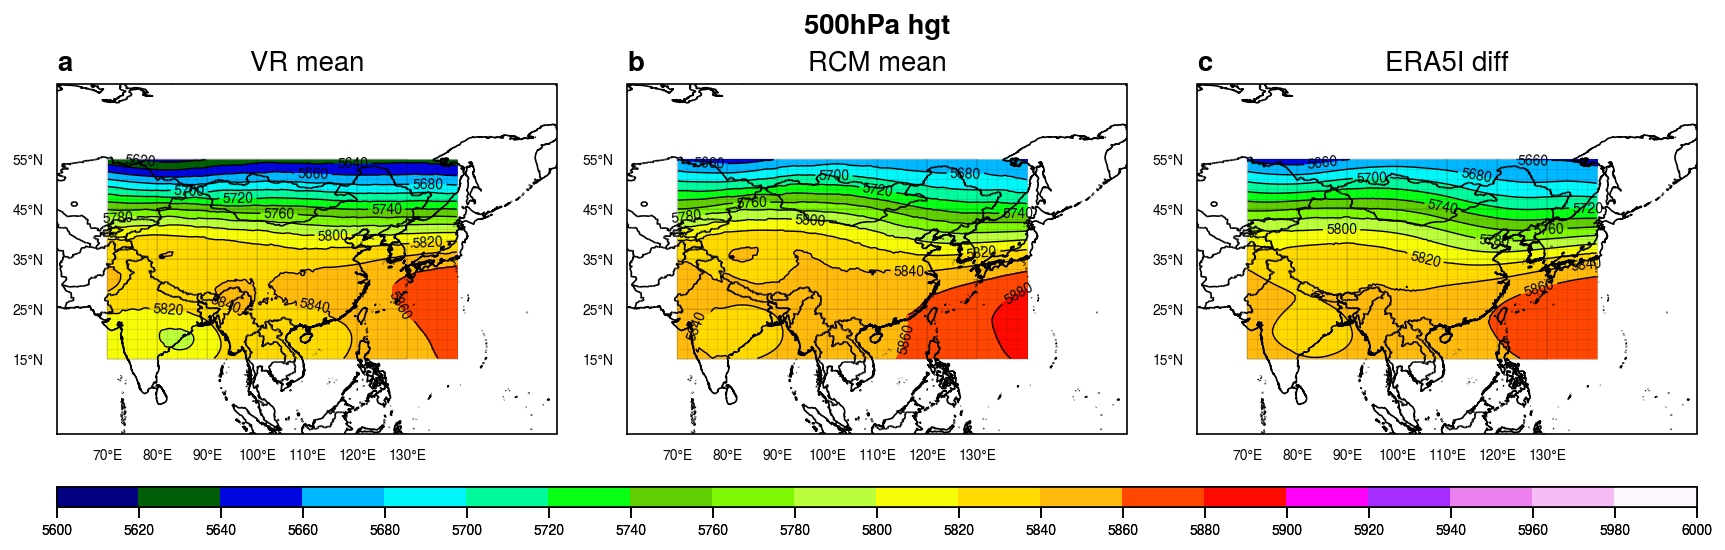

In [5]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

lon = var_3d['vr'].longitude.values
lat = var_3d['vr'].latitude.values

#----- create plot -----
fig, axs = plot.subplots(ncols=3,nrows=1, proj=('cyl'))
m_contour_list = [] # 用于保存contour设置，后续设置colorbar使用
#----- colorbar ticks 统一设置 -----
cmap = 'gist_ncar'
# mean_ticks = np.linspace(int(var_2d['vr'].min()) - 1., int(var_2d['vr'].max())+1,16)
mean_ticks = np.linspace(5600, 6000, 21)

# VR
axs[0].format(title='VR mean')
m_mean = axs[0].contourf(lon, lat, var_2d['vr'].values,\
levels=mean_ticks,cmap=cmap)
m_contour  = axs[0].contour(lon, lat, var_2d['vr'],levels=mean_ticks,color='k',linewidth = .5)
m_contour_list.append(m_contour)

# RCM
axs[1].format(title='RCM mean')
m_mean = axs[1].contourf(lon, lat, var_2d['rcm'],\
levels=mean_ticks,cmap=cmap)
m_contour  = axs[1].contour(lon, lat, var_2d['rcm'],levels=mean_ticks,color='k',linewidth = .5)
m_contour_list.append(m_contour)

axs[2].format(title='ERA5I diff')

m_mean = axs[2].contourf(lon, lat, var_2d['era5i'],\
levels=mean_ticks,cmap=cmap)
m_contour  = axs[2].contour(lon, lat, var_2d['era5i'],levels=mean_ticks,color='k',linewidth = .5)
m_contour_list.append(m_contour)

#----- add color bar-----
# fig.colorbar(m_overlay, loc='b', cmap=cmap, width=0.1)

fig.colorbar(m_mean, loc='b', width=0.1,
ticklabelsize=5,ticks=mean_ticks)

# axs[0].colorbar(m_mean, loc='b', width=0.1,
# ticklabelsize=5,ticks=mean_ticks)

# axs[1].colorbar(m_idctn, loc='b', width=0.1,
# ticklabelsize=5,ticks=idctn_ticks)

# axs[2].colorbar(m_idctn_diff, loc='b',width=0.1,
# ticklabelsize=5,ticks=diff_ticks)


# ----- format setting -----
axs.format(
abc=True,
# lonlim=(70, 140), latlim=(15, 55), coast=True,
lonlim=(60, 160), latlim=(0, 70), coast = True,
reso = 'hi',
#-----GEO axis-----
borders = True,
labels = True,
gridlabelsize = 5,
gridminor = True,
# ticklen = 10,
# borderslinewidth=.5,
# longridminor= False,
# latgridminor= False,
# lonminorlocator = 
longrid  = True,
latgrid  = True,
# latlines = 10,
# lonlines = 10,
lonlocator = np.arange(70,140,10),
latlocator = np.arange(15,65,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="500hPa hgt",
)
#----- add contour tick labels -----
for i,axs_ind in enumerate(m_contour_list):
    axs[i].clabel(axs_ind, inline=True, fontsize=5, colors = 'k', fmt='%4.0f',use_clabeltext=True, inline_spacing=1)
    # axs[i].clabel(axs_ind, inline=True, fontsize=5, colors = 'k', fmt='%.2f',use_clabeltext=True, inline_spacing=1)

#----- save figure -----
fig.patch.set_facecolor('white')
plt.savefig('./output_pic/hgt500_spacemean.png', dpi=500, facecolor= "white")
# plt.savefig('./output_pic/hgt_idctn.png', dpi=300, facecolor= "white")

## 检查地图边界问题

### 用GMT中得到的点进行边界的连线
子图数量起来的话速度较慢

In [6]:
# Load the border data, CN-border-La.dat is download from
# https://gmt-china.org/data/CN-border-La.dat
import cartopy.crs as ccrs
cn_border_file = "/m2data2/yycheng/data_stage/CN-border/CN-border-La.dat"
with open(cn_border_file) as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


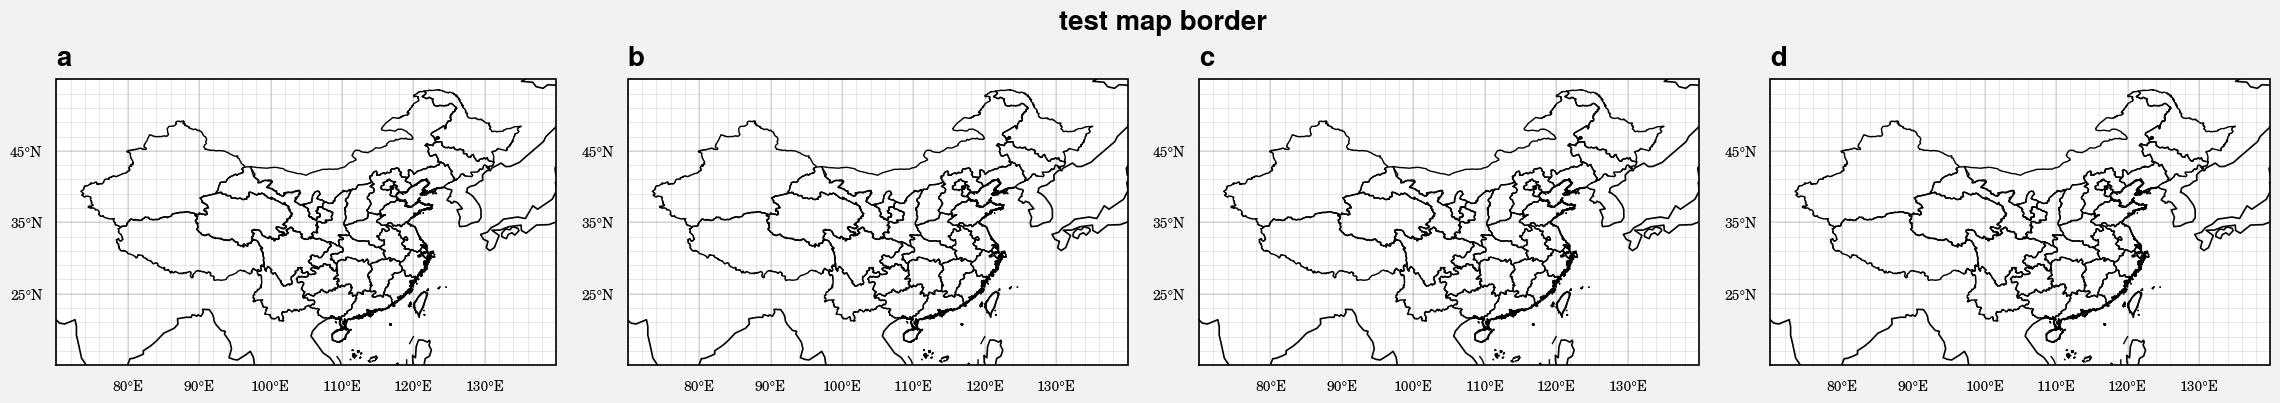

In [7]:
fig, axs = pplt.subplots(ncols=4,nrows=1, proj=('cyl'))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展
# ----- format setting -----

# for ax_ind in axs:
for line in borders:
    # axs.plot(line[0::100], line[1::100], lw = 0.5, color='gray',transform=ccrs.Geodetic())
    axs.plot(line[0::10], line[1::10], lw = 0.5, color='black',transform=ccrs.Geodetic())

    # ax_ind = axs[0]

axs.format(
abc=True,
lonlim=(70, 140), latlim=(15, 55),
# lonlim=(60, 100), latlim=(10, 40),
#----- 地图底图设置 -----
# reso = 'x-hi',
coast = True,
borders = False,
lakes = False,
#-----GEO axis-----
labels = True,
gridlabelsize = 5,
gridminor = True,
# ticklen = 10,
# borderslinewidth=.5,
# longridminor= False,
# latgridminor= False,
# lonminorlocator = 
longrid  = True,
latgrid  = True,
# latlines = 10,
# lonlines = 10,
lonlocator = np.arange(70,140,10),
latlocator = np.arange(15,65,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="test map border",
)

### 用shapefile解决问题
速度相比拉线显然更快

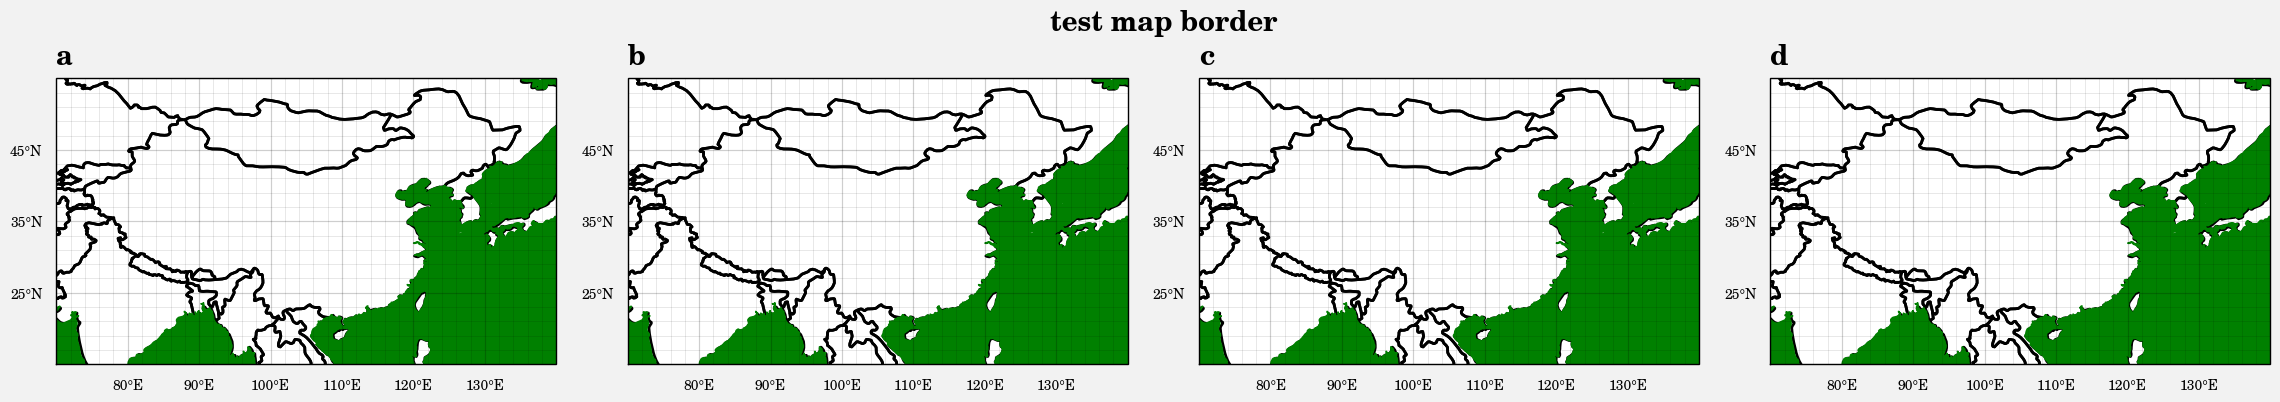

In [8]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## shapefile数据下载的位置：
## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"


fig, axs = pplt.subplots(ncols=4,nrows=1, proj=('cyl'))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

for ax in axs:
    world = shpreader.Reader(world_border_shapefile).geometries()
    ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1, zorder=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='g'))
# ----- format setting -----
axs.format(
abc=True,
lonlim=(70, 140), latlim=(15, 55),
# lonlim=(60, 100), latlim=(10, 40),
#----- 地图底图设置 -----
reso = 'x-hi',
coast = False,
borders = False,
lakes = False,
ocean = False,
#-----GEO axis-----
labels = True,
gridlabelsize = 5,
gridminor = True,
# ticklen = 10,
# borderslinewidth=.5,
# longridminor= False,
# latgridminor= False,
# lonminorlocator = 
longrid  = True,
latgrid  = True,
# latlines = 10,
# lonlines = 10,
lonlocator = np.arange(70,140,10),
latlocator = np.arange(15,65,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="test map border",
)

## 去除掉shapefile中中国的部分，以免和之前的线段重叠

----- skip china! -----
----- skip china! -----
----- skip china! -----
----- skip china! -----


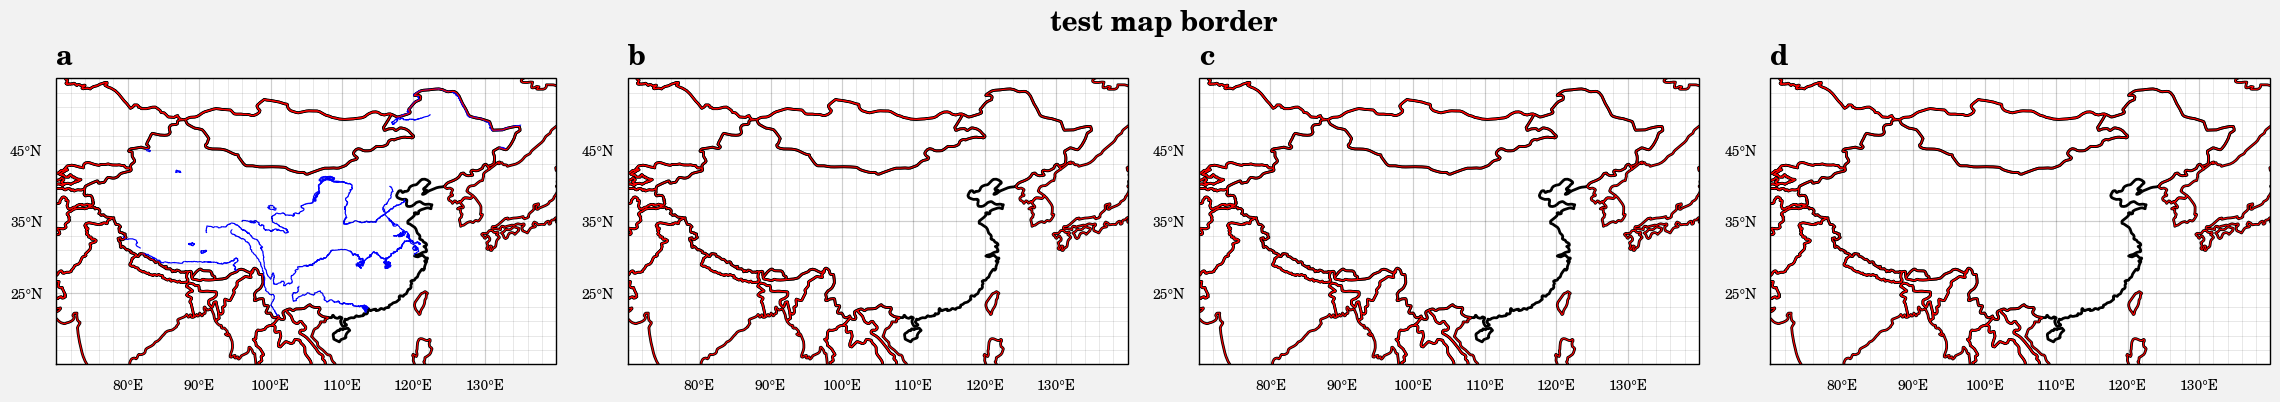

In [14]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## shapefile数据下载的位置：
## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"


fig, axs = pplt.subplots(ncols=4,nrows=1, proj=('cyl'))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

for ax in axs:
    world = shpreader.Reader(world_border_shapefile).geometries()
    ax.add_geometries(world, ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1, zorder=1)
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='g'))


    ## shapefile数据下载的位置：
## http://gaohr.win/site/blogs/2017/2017-04-18-GIS-basic-data-of-China.html
world_border_shapefile = "/m2data2/yycheng/data_stage/CN-border/World/country.shp"
river_border_shapefile =  "/raid52/yycheng/MPAS/REFERENCE/MODEL_CONSTANT/R1/" + "hyd1_4l.shp"

# world = shpreader.Reader(world_border_shapefile).geometries()
world = shpreader.Reader(world_border_shapefile)#.geometries()
river = shpreader.Reader(river_border_shapefile).geometries()

# Filter for a specific country
# 去除掉 China，以免和直接连线相互重合
# world_remove_china = [country for country in reader.records() if ((country.attributes["NAME"] != "China") & (country.attributes["NAME"] != "Taiwan"))]

for ax in axs:
    ax.add_geometries(river, ccrs.PlateCarree(), facecolor='none', edgecolor='b', linewidth=0.4, zorder=1)
    for region in world.records():
        if (region.attributes['NAME'] == 'China'):
            print("----- skip china! -----")
            continue
        ax.add_geometries(region.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth=0.4, zorder=1)
    # ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='b'))
    # ax.add_feature(cfeature.OCEAN) # 添加海洋填色
    # ax.set_global() # added following an answer to my question 并不知道有什么用，先加着
    # ax.gridlines()



# ----- format setting -----
axs.format(
abc=True,
lonlim=(70, 140), latlim=(15, 55),
# lonlim=(60, 100), latlim=(10, 40),
#----- 地图底图设置 -----
reso = 'x-hi',
coast = False,
borders = False,
lakes = False,
ocean = False,
#-----GEO axis-----
labels = True,
gridlabelsize = 5,
gridminor = True,
# ticklen = 10,
# borderslinewidth=.5,
# longridminor= False,
# latgridminor= False,
# lonminorlocator = 
longrid  = True,
latgrid  = True,
# latlines = 10,
# lonlines = 10,
lonlocator = np.arange(70,140,10),
latlocator = np.arange(15,65,10),
lonminorlocator = np.arange(70,140+2,2),
latminorlocator = np.arange(15,55+2,2),
#-----line label-----
# linewidth = 0.5,
# suptitle="3000km-2000km bandpass 500hPa height(1998-06 timemean)",
suptitle="test map border",
)